# 🧠 APVC – Projeto Final
## Sistema de Deteção e Classificação de Equipas de Futebol em Imagens de equipamentos

### 👥 Grupo G11
- **Bernardo Coelho**, nº 98445  
- **Rafael Alexandre Dias Andorinha**, nº 131000  
- **Nuno Martins**, nº 98863  
- **Pedro Fonte Santa**, nº 105306  

---

📅 **Data de entrega:** 15 de Julho  

📊 **Objetivo deste script:**
Este notebook treina a CNN final utilizada no pipeline YOLO + Classificador. O modelo foi treinado exclusivamente com imagens de emblemas recortados automaticamente a partir de fotos reais de equipamentos de futebol obtidas através de web scraping, pode ser visto no link em baixo. Cada imagem foi previamente processada por um modelo YOLOv8, que identificou e recortou as zonas dos logótipos nas camisolas dos jogadores.
Após a deteção, as imagens foram aumentadas com técnicas de data augmentation para expandir o dataset, tornando o modelo mais robusto a variações de iluminação, posição e estilo. Esta abordagem garantiu que a CNN foi treinada com dados altamente semelhantes aos que encontra na fase de inferência, o que se revelou essencial para atingir bons resultados na classificação realista dos clubes durante o pipeline completo.

---

### 🗂️ Dataset:
- [web scraping](https://iscteiul365-my.sharepoint.com/:f:/g/personal/ppfsa1_iscte-iul_pt/Eh6LI078w25Ik7Y3wIC0r7cBcYncaHjGWUdZGqRarBL-Yw?e=rOaxjC)

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms

In [2]:
import torch
print(torch.backends.mps.is_available())


True


In [13]:
# Diretórios
DATASET_DIR = "/Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/augmented-flat-cnn-kit-dataset"
BATCH_SIZE = 32
RANDOM_SEED = 42

# Garantir reprodutibilidade
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Verificar se há GPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)

print("Device:", DEVICE)

Device: mps
Device: mps


### Transformações e divisão do dataset

In [4]:
# Transformações
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Carregamento inicial com ImageFolder
full_dataset = datasets.ImageFolder(DATASET_DIR)

# Lista de índices e classes
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes
print(f"Total de classes: {num_classes}")

# Split dos índices
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
train_idx, valtest_idx = train_test_split(indices, test_size=0.2, random_state=RANDOM_SEED, stratify=[full_dataset.targets[i] for i in indices])
val_idx, test_idx = train_test_split(valtest_idx, test_size=0.5, random_state=RANDOM_SEED, stratify=[full_dataset.targets[i] for i in valtest_idx])

# Subsets com transformações apropriadas
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Substituir transformações em cada subset
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Total de classes: 79


### Modelo, loss function, otimizador e setup de treino

In [5]:
# Carregar modelo pré-treinado
model = models.resnet18(pretrained=True)

# Congelar pesos da rede base
for param in model.parameters():
    param.requires_grad = False

# Substituir a última camada para o número de clubes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

# Enviar modelo para o dispositivo
model = model.to(DEVICE)

# Função de perda (problema multiclasse)
criterion = nn.CrossEntropyLoss()

# Otimizador (só para a camada final)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# Parâmetros do treino
NUM_EPOCHS = 50
PATIENCE = 5  # early stopping
best_val_loss = float('inf')
epochs_no_improve = 0
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

# Caminho para guardar o melhor modelo
BEST_MODEL_PATH = "best_model.pt"


/Users/pedrofs/ISCTE/Mestrado/ComputerVision/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pedrofs/ISCTE/Mestrado/ComputerVision/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loop de treino 

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.float() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [7]:
def validate(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    epoch_loss = val_loss / len(dataloader.dataset)
    epoch_acc = val_corrects.float() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
for epoch in range(NUM_EPOCHS):
    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc.item())
    history["val_acc"].append(val_acc.item())

    print(f"Treino — Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Validação — Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        print(" Novo melhor modelo encontrado. A guardar...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f" Sem melhoria. Early stopping em {epochs_no_improve}/{PATIENCE}")

    if epochs_no_improve >= PATIENCE:
        print(" Early stopping ativado.")
        break

### Visualização do desempenho do treino

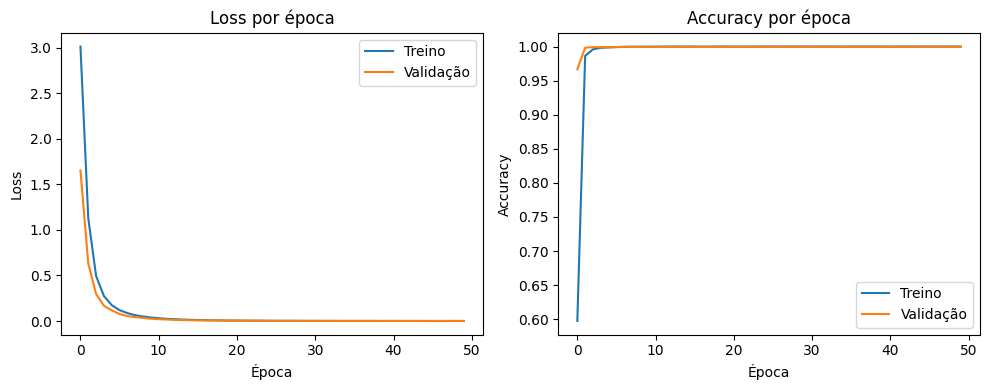

In [9]:
# Gráfico da loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Treino")
plt.plot(history["val_loss"], label="Validação")
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

# Gráfico da accuracy
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Treino")
plt.plot(history["val_acc"], label="Validação")
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### Avaliação no conjunto de teste

In [10]:
# Carregar o melhor modelo
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

# Prever o conjunto de teste
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Métricas globais
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
F1 Score (macro): 1.0000


### Matrizes de confusão por liga

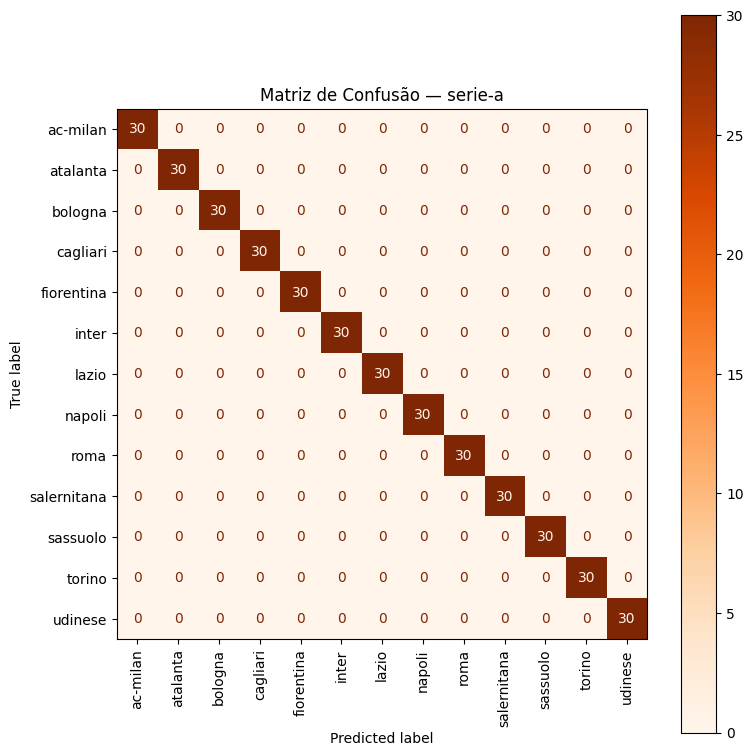

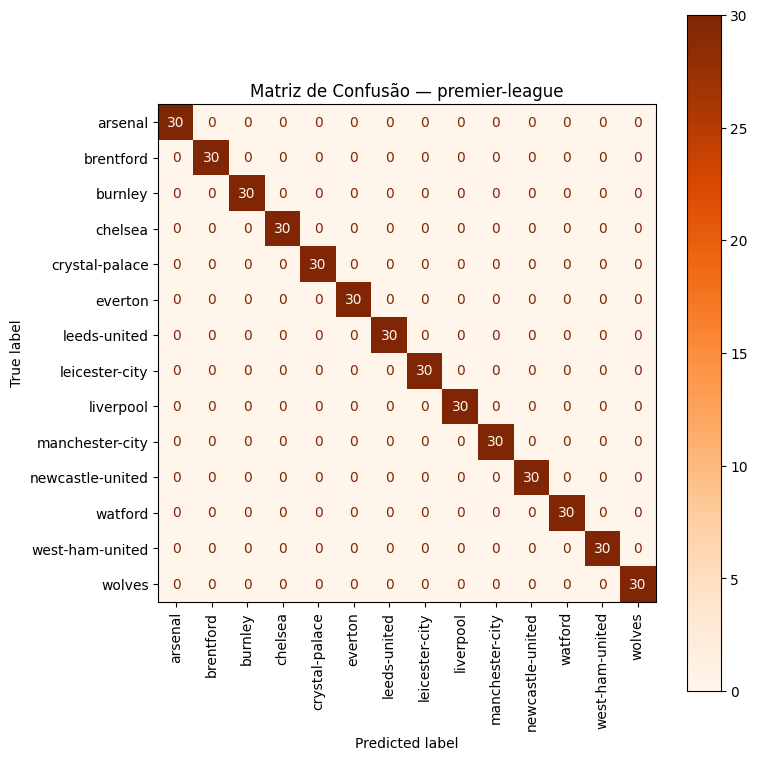

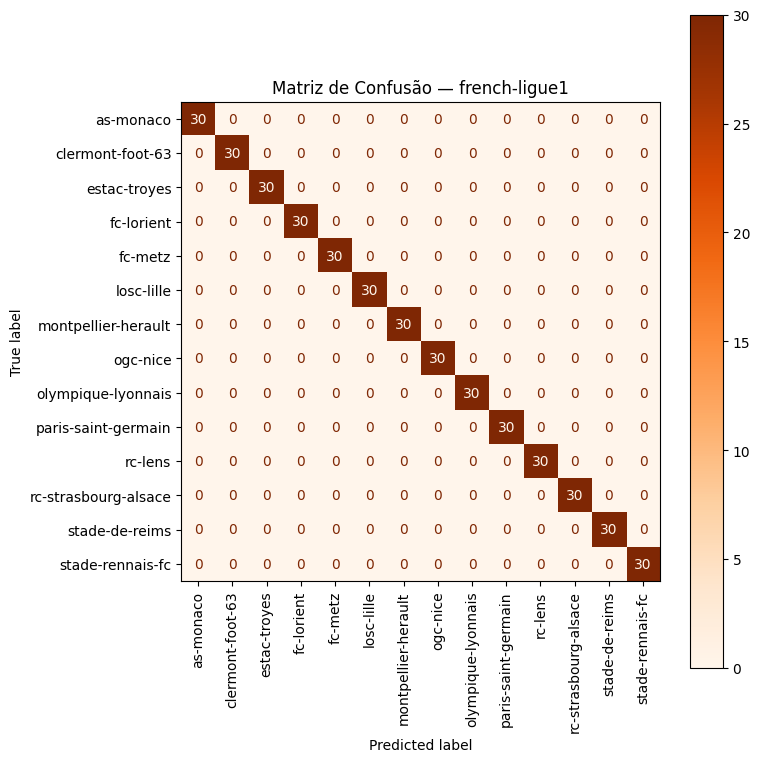

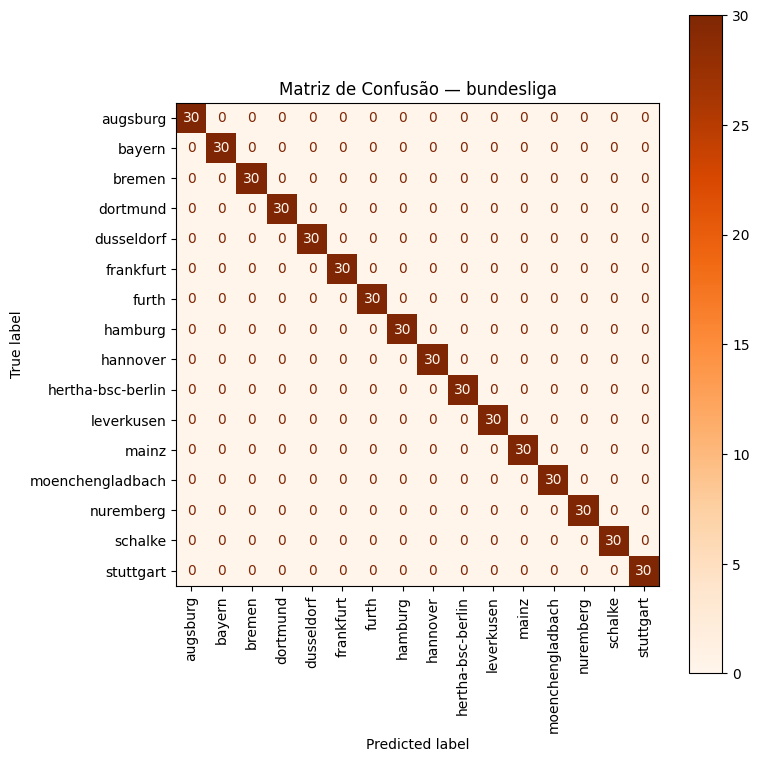

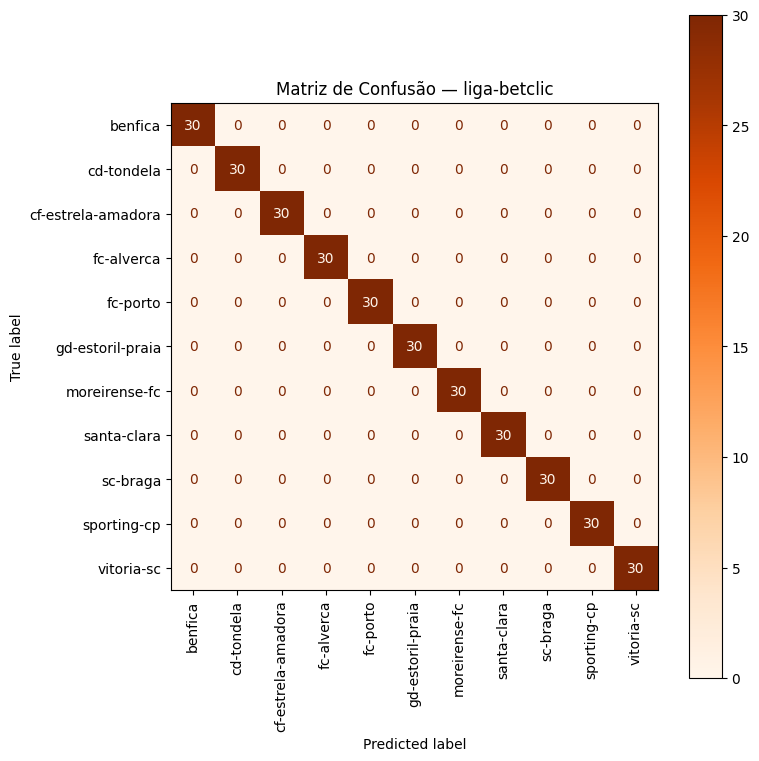

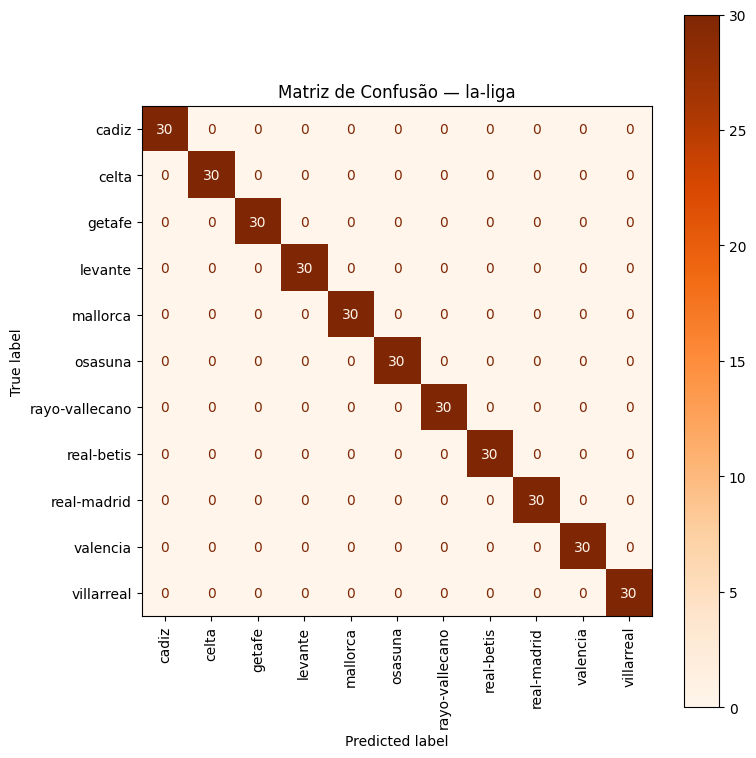

In [11]:
import json
from collections import defaultdict

# Carregar o mapeamento
with open(os.path.join(DATASET_DIR, "..", "augmented-flat", "clube_para_liga.json")) as f:
    clube_para_liga = json.load(f)

# Inverter mapping: liga → [classes]
liga_to_classes = defaultdict(list)
for i, name in enumerate(class_names):
    liga = clube_para_liga.get(name, "desconhecida")
    liga_to_classes[liga].append(i)

# Criar matrizes por liga
for liga, class_indices in liga_to_classes.items():
    liga_labels = []
    liga_preds = []

    for yt, yp in zip(y_true, y_pred):
        if yt in class_indices:
            liga_labels.append(yt)
            liga_preds.append(yp)

    if not liga_labels:
        continue

    cm_liga = confusion_matrix(liga_labels, liga_preds, labels=class_indices)
    fig, ax = plt.subplots(figsize=(8, 8))
    labels = [class_names[i] for i in class_indices]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_liga, display_labels=labels)
    disp.plot(ax=ax, xticks_rotation=90, cmap="Oranges")
    plt.title(f"Matriz de Confusão — {liga}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()